In [23]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits

# Grizli
import grizli
from grizli.model import GrismFLT
import pysynphot as S

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits")

root = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits" # Change filename with this variable
direct_file = "ready_direct_{0}".format(root)
seg_file = "gaussian_seg.fits"

In [25]:
# Create Grizli GrismFLT instance
pad=100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=pad)

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/keith/astr/research_astr/summer-roman-project/psf/notebooks/gaussian_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [26]:
# Read in Table
hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format='ascii')

# Define SED directory
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

# Loop through objects, dispersing with objects' unique spectrum templates
for object in hlss_tbl:

    # Pull variables from table
    id = object["NUMBER"]
    mag = object["MAG_F1500W"]

    # Handle SED differently if STAR vs GALAXY
    if object["MODIMAGE"]:
        sed = "/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/ukg0v.fits"
        file = fits.open(sed)
        wave = np.linspace(10000,20000,2000)
        flux = file[0].data[1770:3770]
        file.close()
        z = 0

    else:
        sed = "SED:rest:gal.{0}.fits".format(object["SPECTEMP"])
        sed_path = os.path.join(SED_dir, sed)
        spectrum = Table.read(sed_path, format="fits")
        wave = spectrum["wavelength"]
        flux = spectrum["flux"]
        z = object['Z']

    # Compute pysynphot Spectrum
    spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam").redshift(z)
    spec = spec.renorm(mag, "abmag", bp)
    spec.convert("flam")

    roman_sim.compute_model_orders(id, mag=mag, compute_size=False, size=77, 
                                   in_place=True, store=False, spectrum_1d=[spec.wave, spec.flux], is_cgs=True)

ID 74 not found in segmentation image
ID 231 not found in segmentation image
ID 554 not found in segmentation image
ID 1057 not found in segmentation image
ID 1443 not found in segmentation image
ID 3469 not found in segmentation image
ID 3714 not found in segmentation image
ID 4268 not found in segmentation image
ID 4322 not found in segmentation image
ID 4323 not found in segmentation image
ID 4378 not found in segmentation image
ID 4858 not found in segmentation image
ID 4860 not found in segmentation image
ID 4929 not found in segmentation image
ID 5460 not found in segmentation image
ID 5479 not found in segmentation image
ID 5480 not found in segmentation image
ID 5548 not found in segmentation image
ID 5812 not found in segmentation image
ID 6019 not found in segmentation image
ID 6694 not found in segmentation image
ID 6879 not found in segmentation image
ID 7891 not found in segmentation image
ID 8934 not found in segmentation image
ID 9432 not found in segmentation image
ID 9

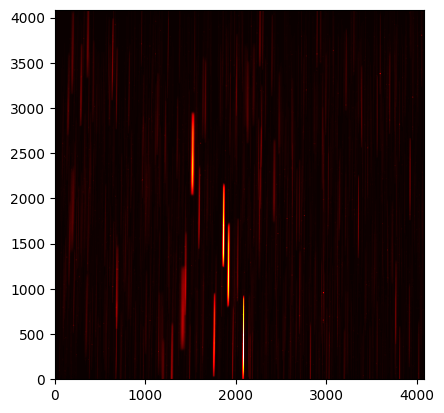

In [33]:
upright_img = np.rot90(roman_sim.model[pad:-pad,pad:-pad])
plt.imshow(upright_img, origin='lower', vmin=0, vmax=1.6016138792037964, cmap='hot')

In [28]:
roman_sim.model.max()

7.074063

In [29]:
raise Exception("Pause before saving")

Exception: Pause before saving

In [ ]:
# Primary HDU is opened and closed above. Comment out direct_fits.close() if you plan to save here.
file = fits.open(direct_file)
header = file[1].header
PrimaryHDU = file[0]

ImageHDU = fits.ImageHDU(data=upright_img, header=header, name='SCI')
err_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='ERR')
DQ_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='DQ')

hdul = [PrimaryHDU, ImageHDU, err_HDU, DQ_HDU]

fits.HDUList(hdul).writeto("gauss_seg_{0}".format(root), overwrite=True)

file.close()